# Comparison of an SMPI trace with a real trace for HPL

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def filter_pajeng(pajeng_output, keep):
    lines = pajeng_output.split(b'\n')
    lines = [l for l in lines if l.startswith(keep.encode())]
    return b'\n'.join(lines)

def _read_paje_state(archive_name, csv_name, has_msg_size=False, replace_func=('MPI', 'MPI')):
    columns=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function']
    if has_msg_size:
        columns.append('tmp')
    df = read_csv(archive_name, csv_name, columns=columns, filter_func=lambda x: filter_pajeng(x, 'State'))
    df['function'] = df['function'].str.replace(*replace_func).str.strip()  # for some reason Simgrid uses PMPI_Wait and not MPI_Wait
    df['msg_size'] = -1
    if has_msg_size:
        df.loc[df['function'].isin(['MPI_Recv', 'MPI_Send', 'MPI_Isend', 'MPI_Irecv']), 'msg_size'] = df['tmp']
        df['msg_size'] = df['msg_size'].astype(int)
    df['rank'] = df['rank'].str.slice(5).astype(int)  # changing 'rank42' into 42
    return df

def read_mpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name)
    return df

def read_smpi_state(archive_name, csv_name):
    df = _read_paje_state(archive_name, csv_name, True, ('PMPI', 'MPI'))
    df['rank'] = -df['rank']  # in SMPI, we have 'rank-42' and not 'rank42', so there remains a - that we should remove
    return df

def read_smpi_link(archive_name, csv_name):
    df = read_csv(archive_name, csv_name,
                  columns=['type', 'level', 'container', 'start', 'end', 'duration', 'commType', 'src', 'dst', 'msg_size'],
                  filter_func=lambda x: filter_pajeng(x, 'Link'))
    df['src'] = df['src'].str.slice(6).astype(int)  # changing 'rank42' into 42
    df['dst'] = df['dst'].str.slice(6).astype(int)  # changing 'rank42' into 42
#    df['remote'] = (df['src'] // 32) != (df['dst'] // 32)
    return df

def read_archive(archive_name, mode, drop_func=['MPI_Comm_rank', 'MPI_Comm_size', 'MPI_Comm_split', 'MPI_Comm_free', 'MPI_Init', 'MPI_Finalize']):
    assert mode in ('reality', 'simgrid')
    print('# Mode: %s' % mode)
    blas_trace = read_csv(archive_name, 'trace_blas_0.csv')
    print('\tBLAS trace: %6d lines' % len(blas_trace))
    blas_trace['start'] = blas_trace.timestamp
    blas_trace['end'] = blas_trace.timestamp + blas_trace.duration
    blas_trace = blas_trace[['function', 'start', 'end', 'rank']]
    blas_trace['msg_size'] = -1
    blas_trace['kind'] = 'BLAS'
    if mode == 'reality':
        mpi_trace = read_mpi_state(archive_name, 'trace_mpi_0.csv')
    else:
        mpi_trace = read_smpi_state(archive_name, 'trace_mpi_0.csv')
    print('\tMPI  trace: %6d lines' % len(mpi_trace))
    mpi_trace = mpi_trace[['function', 'start', 'end', 'rank', 'msg_size']]
    mpi_trace['kind'] = 'MPI'
    df = pandas.concat([blas_trace, mpi_trace])
    df['mode'] = mode
    df['rank+1'] = df['rank'] + 1
    old_len = len(df)
    df = df[~df['function'].str.strip().isin(drop_func)]
    print('Removed %d events with functions in %s' % (old_len-len(df), ', '.join(drop_func)))
    if mode == 'reality':
        df_links = None
    else:
        df_links = read_smpi_link(archive_name, 'trace_mpi_0.csv')
    return df, df_links

reality_file = 'grenoble_2018-12-05_1824210.zip'
simgrid_file = '../smpi_hpl/grenoble_2018-12-05_1824218.zip'

simgrid_time = read_csv(simgrid_file, 'results.csv')['time'].unique()
reality_time = read_csv(reality_file, 'results.csv')['time'].unique()
assert len(simgrid_time) == 1 and len(reality_time) == 1
simgrid_time = simgrid_time[0]
reality_time = reality_time[0]

trace_reality, link_reality = read_archive(reality_file, 'reality')
trace_simgrid, link_simgrid = read_archive(simgrid_file, 'simgrid')
traces = pandas.concat([trace_reality, trace_simgrid])

traces.head()

# Mode: reality
	BLAS trace:   5884 lines
	MPI  trace:  23290 lines
Removed 6412 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize
# Mode: simgrid
	BLAS trace:   3372 lines
	MPI  trace:   9984 lines
Removed 16 events with functions in MPI_Comm_rank, MPI_Comm_size, MPI_Comm_split, MPI_Comm_free, MPI_Init, MPI_Finalize


,function,start,end,rank,msg_size,kind,mode,rank+1
0,dtrsm,174.211,174.211025,0,-1,BLAS,reality,1
1,dgemm,174.211,174.211897,0,-1,BLAS,reality,1
2,dtrsm,174.213,174.213000,0,-1,BLAS,reality,1
3,dgemm,174.213,174.213000,0,-1,BLAS,reality,1
4,dtrsm,174.213,174.213002,0,-1,BLAS,reality,1


## Checking the parameters

In [2]:
read_csv(reality_file, 'exp.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process
0,250000,128,2,4,1,2,2,1,0,8,1,32


In [3]:
read_csv(simgrid_file, 'exp_smpi.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,250000,128,2,4,1,2,2,1,0,8,1,32,2.548998e-12,0.000099,4.524788e-12,0.00004


In [4]:
print(zipfile.ZipFile(simgrid_file).read('dahu.xml').decode('ascii'))

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;633

In [5]:
for mode in traces['mode'].unique():
    for kind in trace_reality['kind'].unique():
        df = traces[(traces['mode'] == mode) & (traces['kind'] == kind)]
        print(mode, kind, df.start.min(), df.end.max())

reality BLAS 174.21099999999998 192.05969
reality MPI 5.1e-05 436.26892300000003
simgrid BLAS 0.099048 13.036150000000001
simgrid MPI 0.0 13.048001


## Visualizing the traces

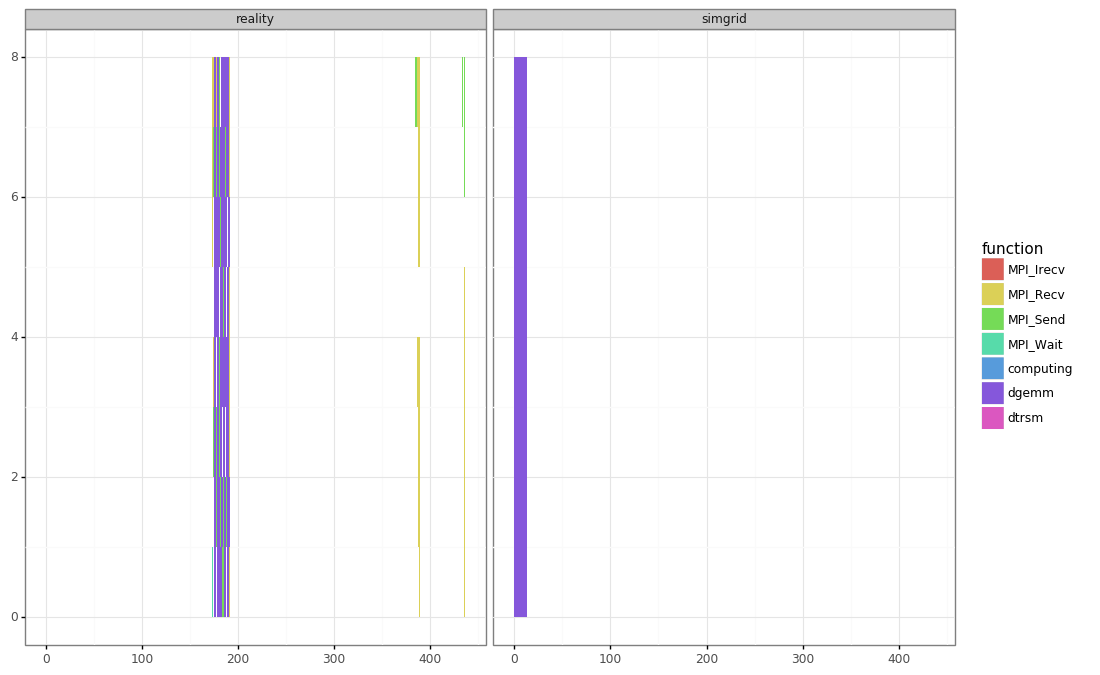

<ggplot: (8785438949282)>

In [6]:
def plot(df, wrap=['mode', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

plot(traces, ['mode'])

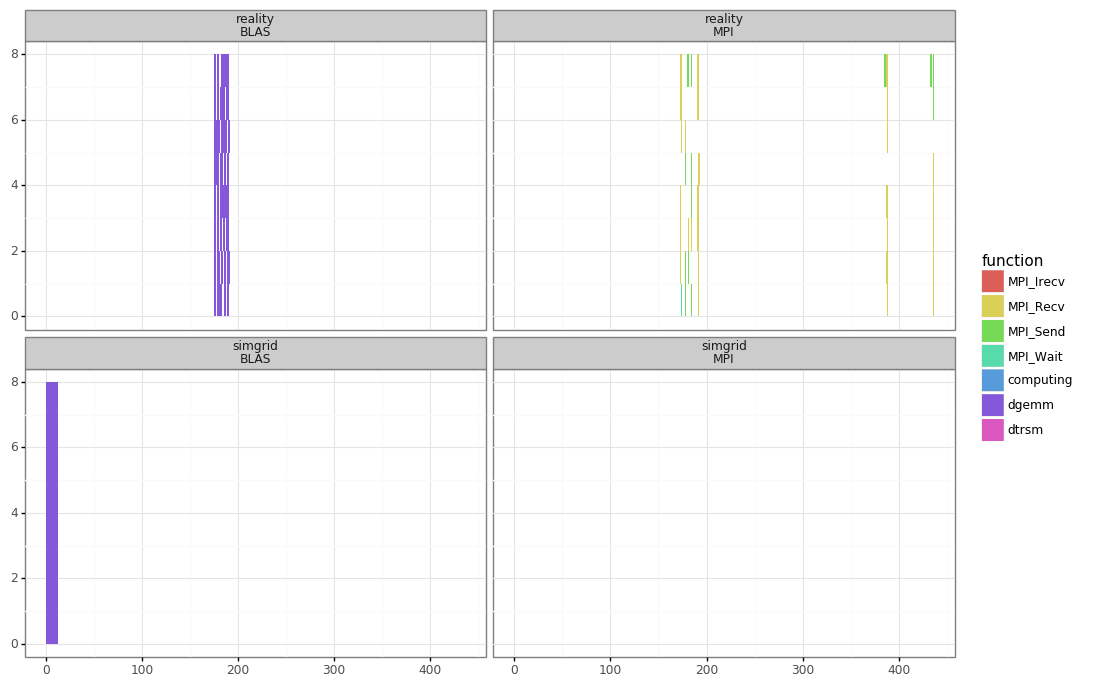

<ggplot: (8785431089514)>

In [7]:
plot(traces)

### Removing the initialization in the reality trace

In [8]:
real_start = trace_reality[(trace_reality.start > 10)].start.min()
print('Real start: %f' % real_start)
assert real_start > 100  # should be about 170 for our problem size
trace_reality = trace_reality[trace_reality.start >= real_start]
trace_reality['start'] -= real_start
trace_reality['end'] -= real_start
traces = pandas.concat([trace_simgrid, trace_reality])

Real start: 172.532298


### Removing the finalization in the reality trace

In [9]:
real_end = trace_reality[trace_reality.end < 150].end.max()
print('Real end: %f' % real_end)
assert real_end < 25  # should be about 20 for our problem size
trace_reality = trace_reality[trace_reality.end <= real_end]
traces = pandas.concat([trace_simgrid, trace_reality])

Real end: 20.548224


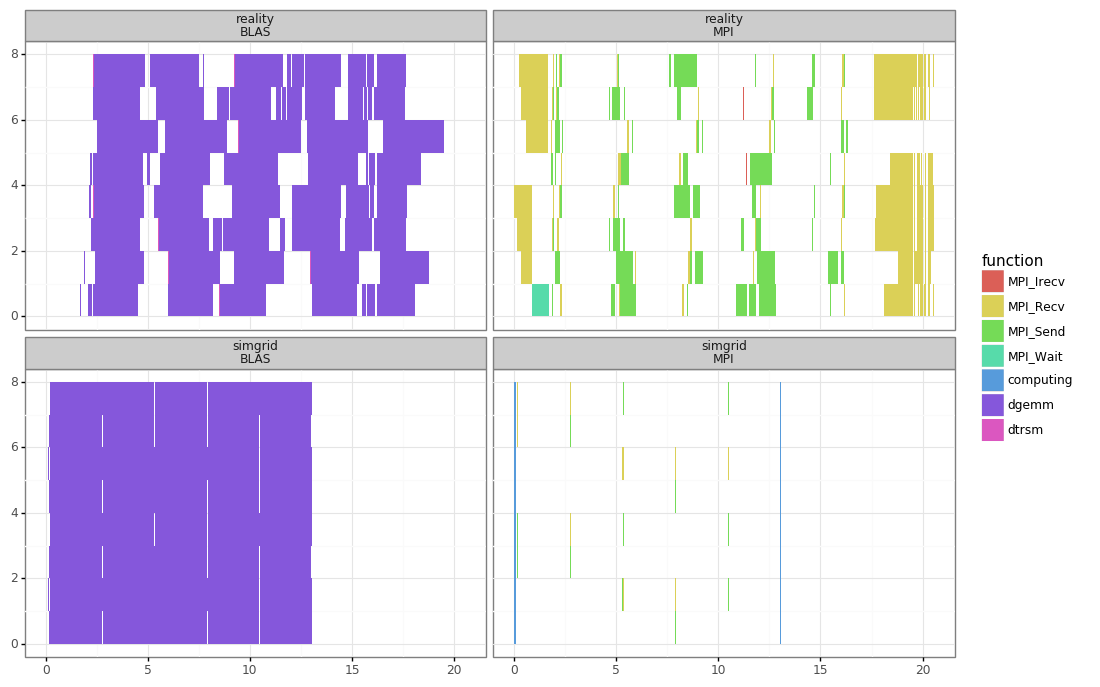

<ggplot: (-9223363251394299157)>

In [10]:
plot(traces)

### Zooming on the trace 

In [11]:
def plot_bounded(df, start, end, ranks, wrap=['mode', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

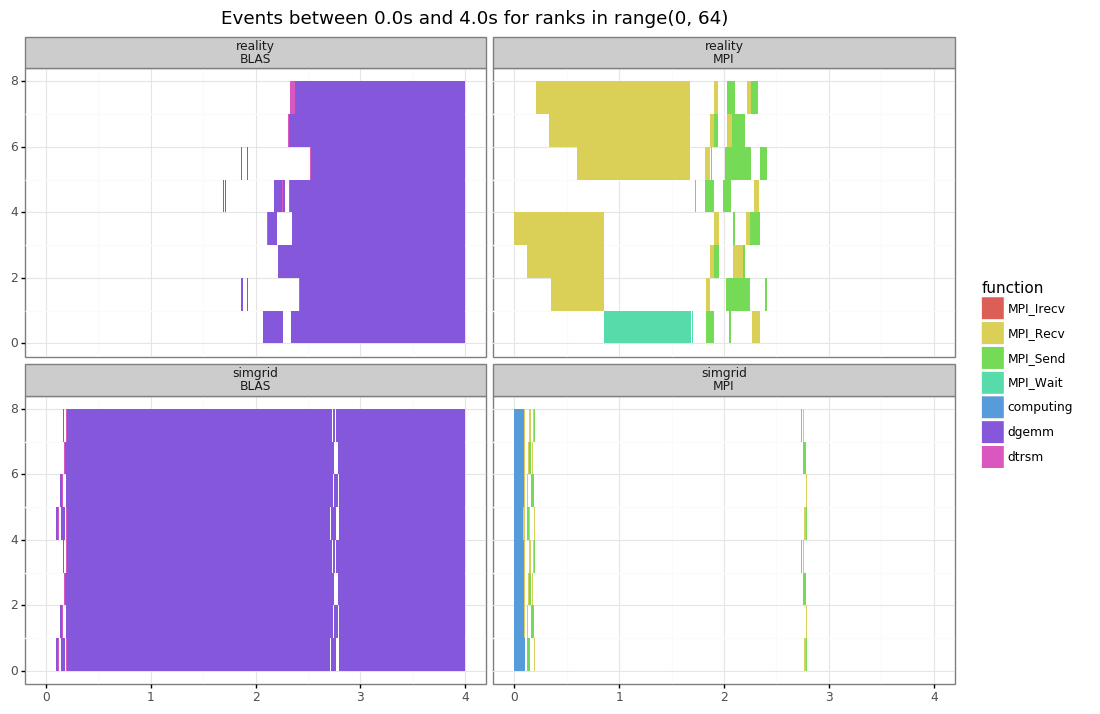

<ggplot: (8785366270924)>

In [12]:
plot_bounded(traces, 0, 4, range(64))

## Plotting the links

In [13]:
def draw_plot(state_dataframe, link_dataframe, time_interval=None, ranks=None):
    if time_interval is None:
        time_interval = -float('inf'), float('inf')
        time_str = 'for the whole experiment'
    else:
        time_str = 'between %.1fs and %.1fs' % time_interval
    if ranks is None:
        ranks = range(0, 1000000)
        rank_str = 'for all the ranks'
    else:
        rank_str = 'for ranks in %s' % ranks
    tmp_state = state_dataframe[(state_dataframe['start'] >= time_interval[0]) & (state_dataframe['end'] <= time_interval[1]) & (state_dataframe['rank'].isin(ranks))].copy()
    tmp_state['rank+1'] = tmp_state['rank'] + 1
    tmp_link = link_dataframe[(link_dataframe['start'] >= time_interval[0]) & (link_dataframe['end'] <= time_interval[1]) & (link_dataframe['src'].isin(ranks)) & (link_dataframe['dst'].isin(ranks))]

    gc = ggplot(tmp_state) + \
        geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) +\
        theme_bw() + xlab('Time') + ylab('Rank') + theme() + ggtitle('Events %s %s' % (time_str, rank_str))
#    for i in set((tmp_state['rank'] // 32)*32):
#        if i <= 0:
#            continue
#        gc += geom_hline(yintercept=i, linetype='dashed', color='red')
    print(gc)
#    gc += geom_segment(tmp_link, aes(x = 'start', y = 'src', xend = 'end', yend = 'dst', color='remote'), arrow = arrow(length = 0.1))
    gc += geom_segment(tmp_link, aes(x = 'start', y = 'src', xend = 'end', yend = 'dst'), arrow = arrow(length = 0.1))
    print(gc)

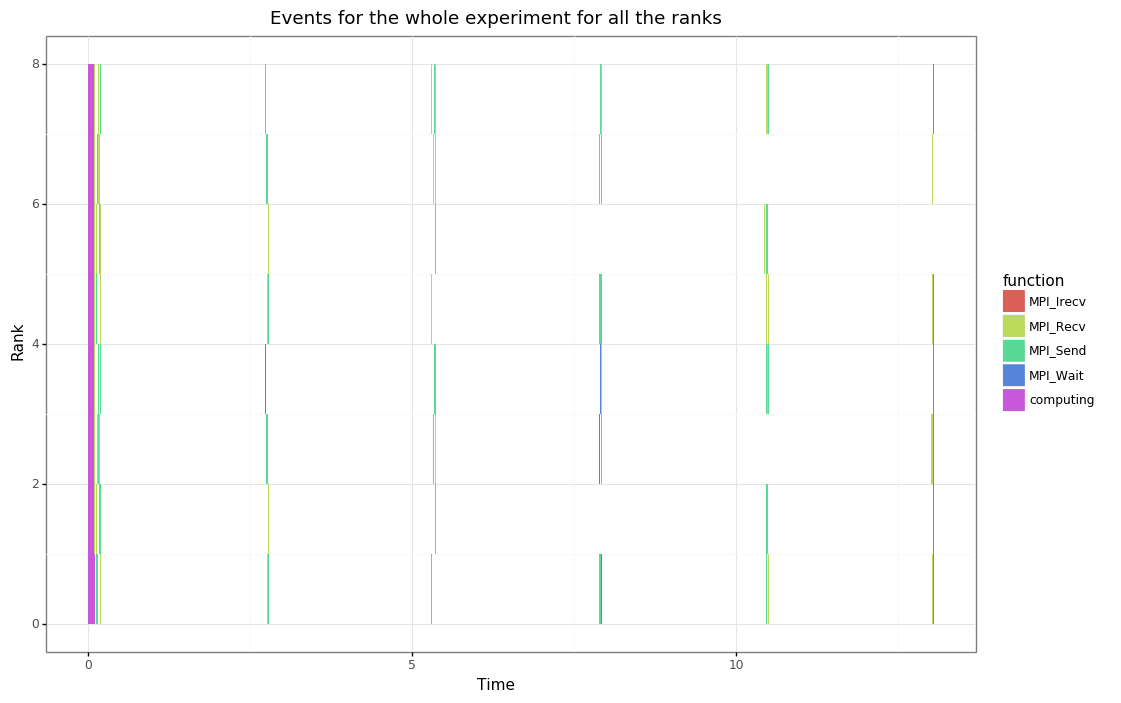

<ggplot: (-9223363251463868195)>


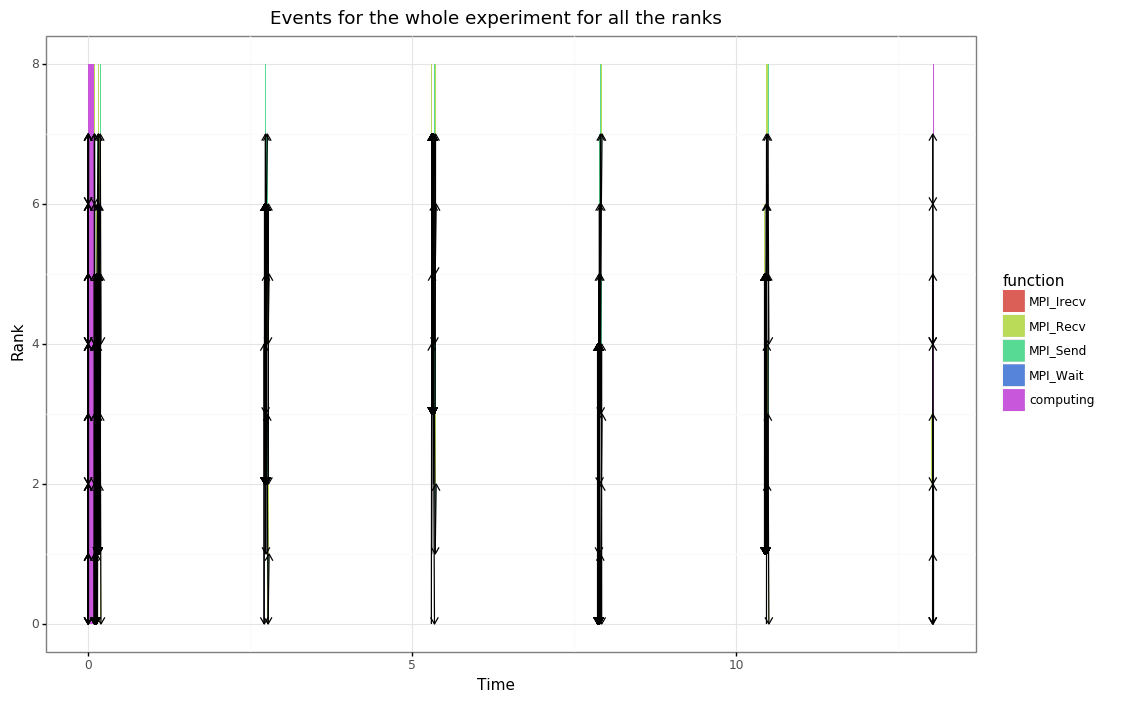

<ggplot: (-9223363251463868195)>


In [14]:
draw_plot(trace_simgrid[trace_simgrid['kind'] == 'MPI'], link_simgrid)

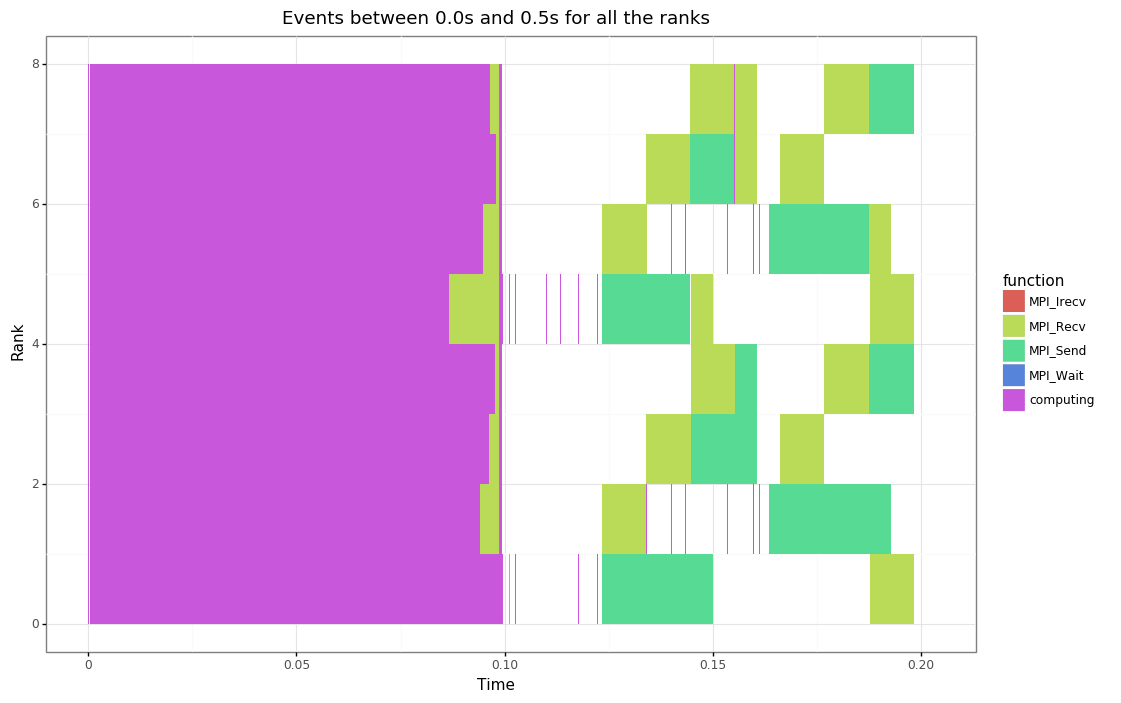

<ggplot: (-9223363251466447847)>


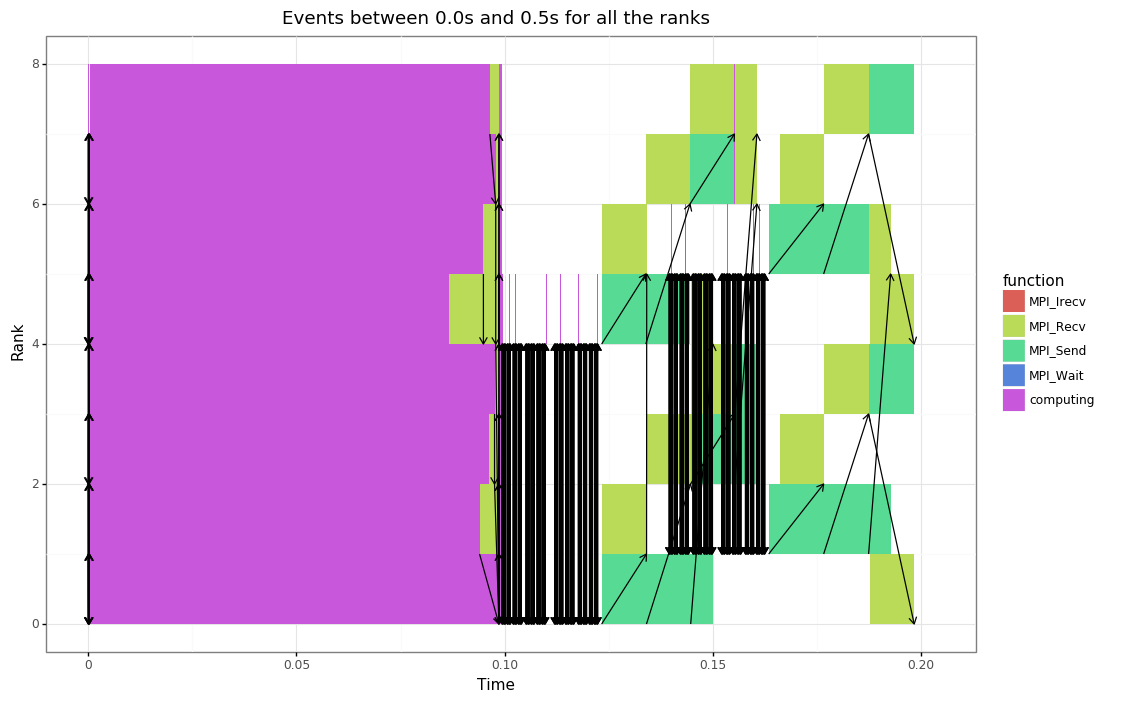

<ggplot: (-9223363251466447847)>


In [15]:
draw_plot(trace_simgrid[trace_simgrid['kind'] == 'MPI'], link_simgrid, time_interval=(0, 0.5))

## Plotting the total time spent in each function

In [16]:
def plot_total_duration(df, function):
    df = df[df.function == function][['rank', 'mode', 'start', 'end']].copy()
    df['duration'] = df['end'] - df['start']
    df = df.groupby(['rank', 'mode']).sum().reset_index()
    plot = ggplot(df, aes(x='rank', y='duration', color='mode')) + geom_point() + theme_bw() + expand_limits(y=0) + ggtitle('Total time spent in function %s' % function)
    print(plot)
    df_reality = df[df['mode'] == 'reality']
    df_simgrid = df[df['mode'] == 'simgrid']
    df = df_reality.set_index('rank').join(df_simgrid.set_index('rank'), rsuffix='_simgrid').reset_index()
    df['difference'] = (df['duration_simgrid'] - df['duration'])/df['duration'] * 100
    max_point = df[df.difference.abs() == df.difference.abs().max()]
    max_rank = list(max_point['rank'])[0]
    max_diff = list(max_point['difference'])[0]
    plot = ggplot(df, aes(x='rank', y='difference')) + geom_point() + theme_bw() + ggtitle('Difference in the total time spent in function %s' % function)
    plot = plot + ylab('duration difference (%)') + geom_hline(yintercept=0, color='red')
    ranks = list(df['rank'])
    mid_rank = (max(ranks) + min(ranks)) / 2
    shift = -1 if max_rank > mid_rank else +1
    plot = plot + annotate('text', label='rank %d, error of %.2f%%' % (max_rank, max_diff), x=max_rank+shift*2, y=max_diff*1.05) + annotate('segment', x=max_rank+shift, y=max_diff*1.05, xend=max_rank, yend=max_diff, size=0.5)
    print(plot)

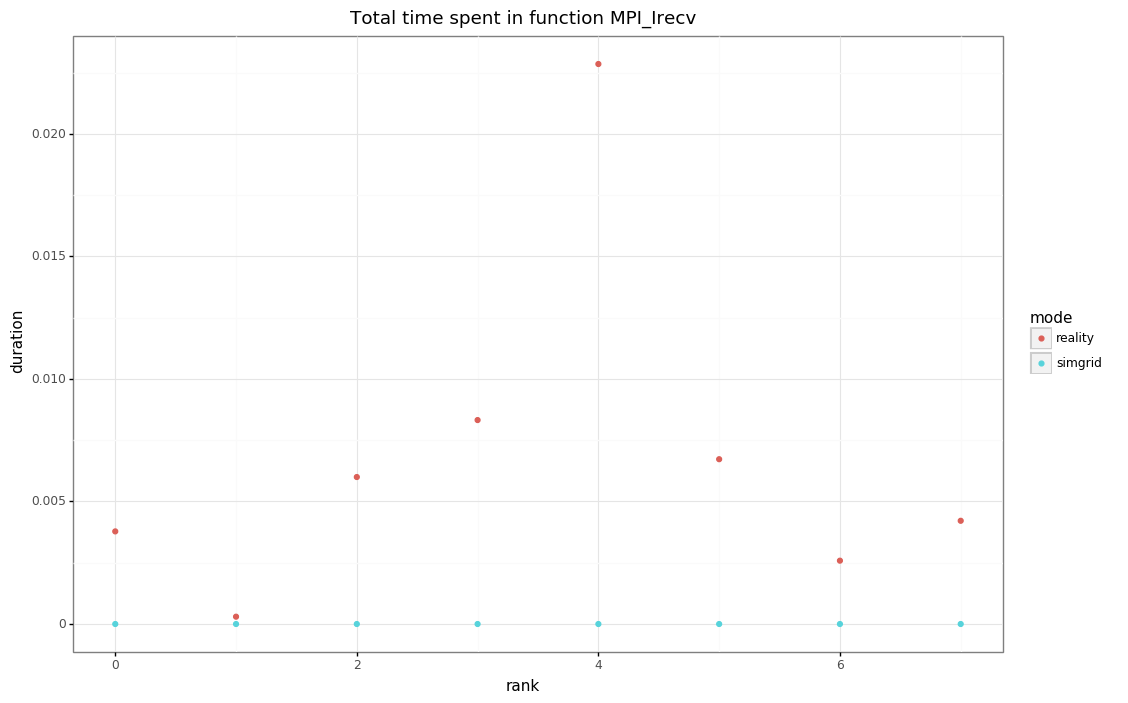

<ggplot: (-9223363251466234750)>


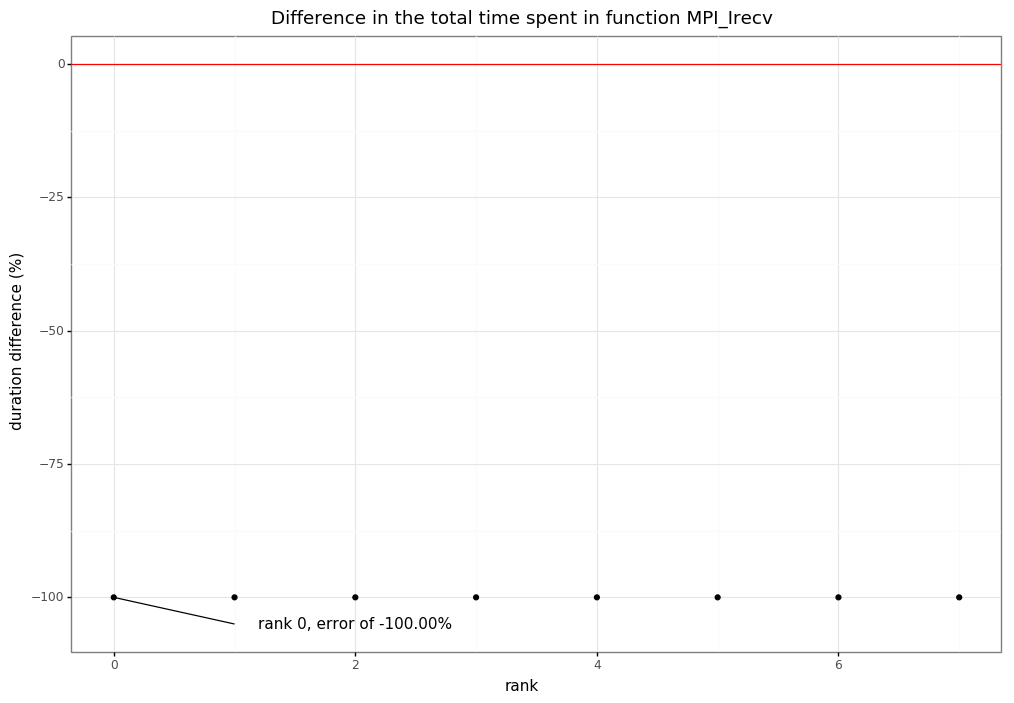

<ggplot: (-9223363251424195836)>


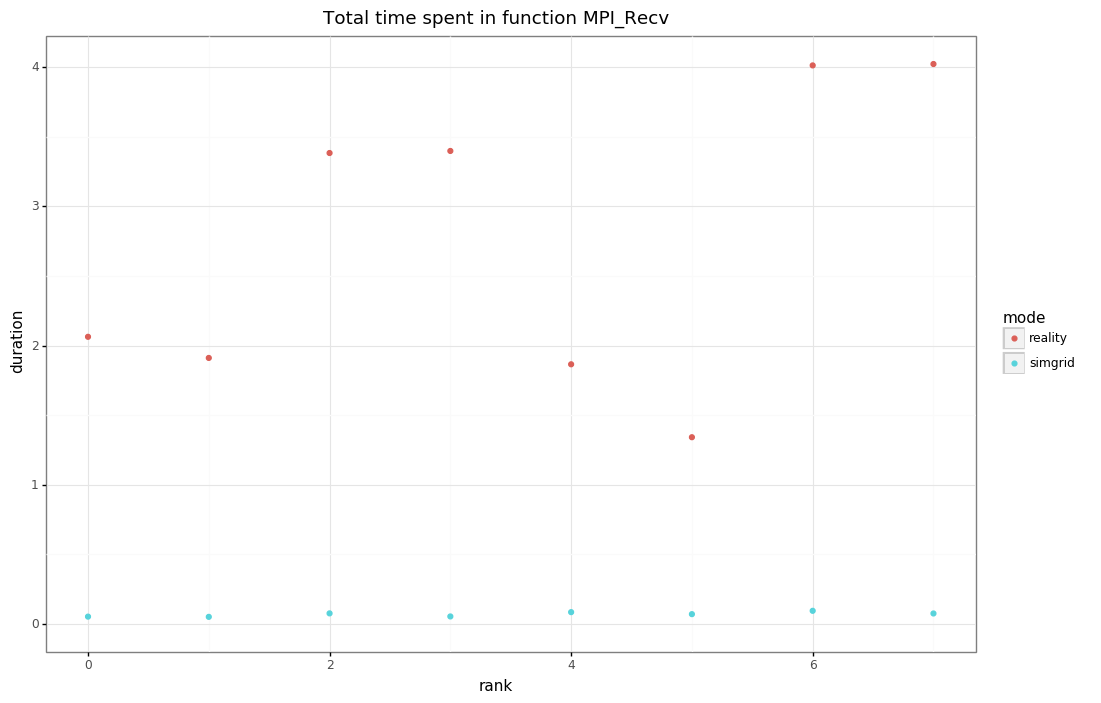

<ggplot: (8785430582287)>


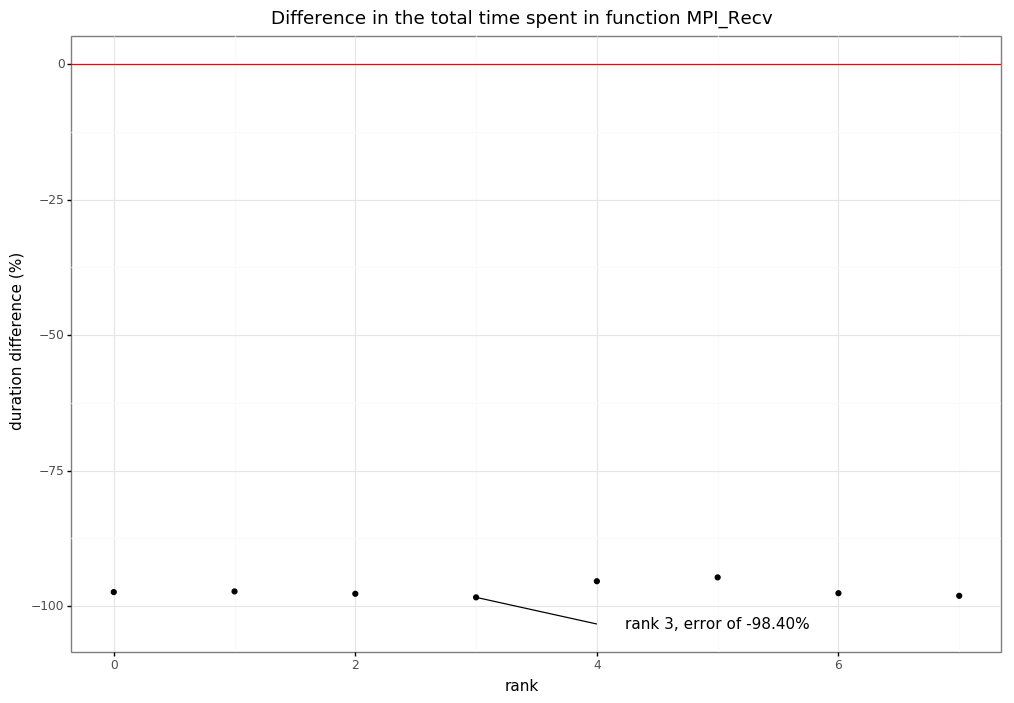

<ggplot: (-9223363251424240675)>


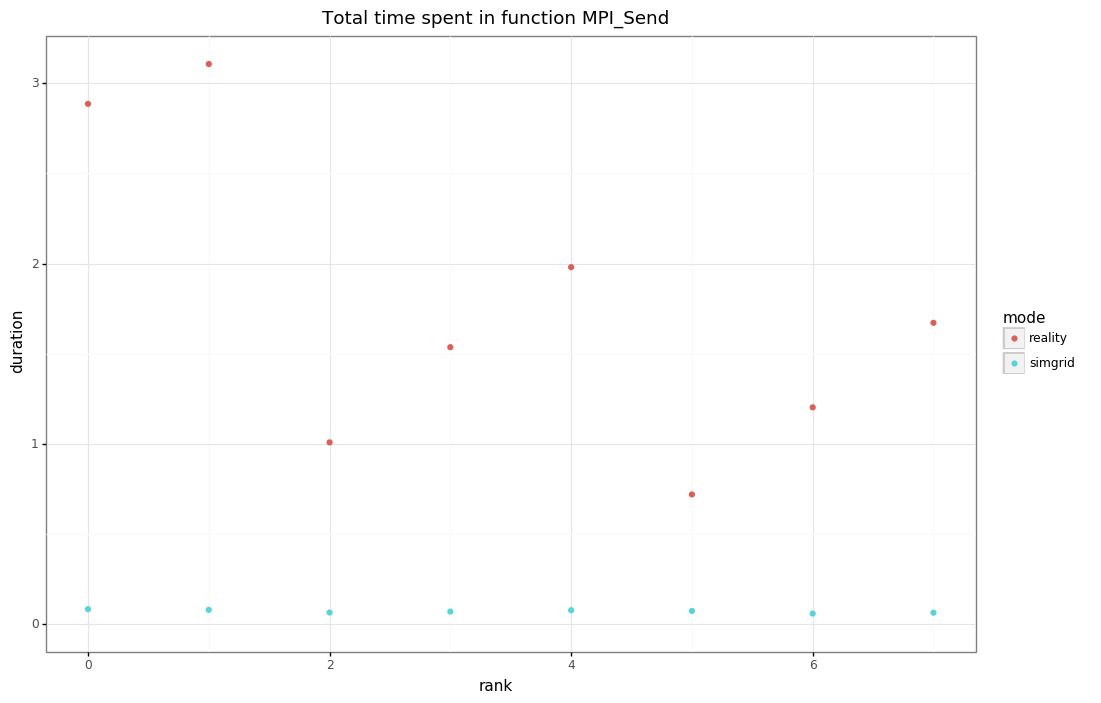

<ggplot: (8785430636534)>


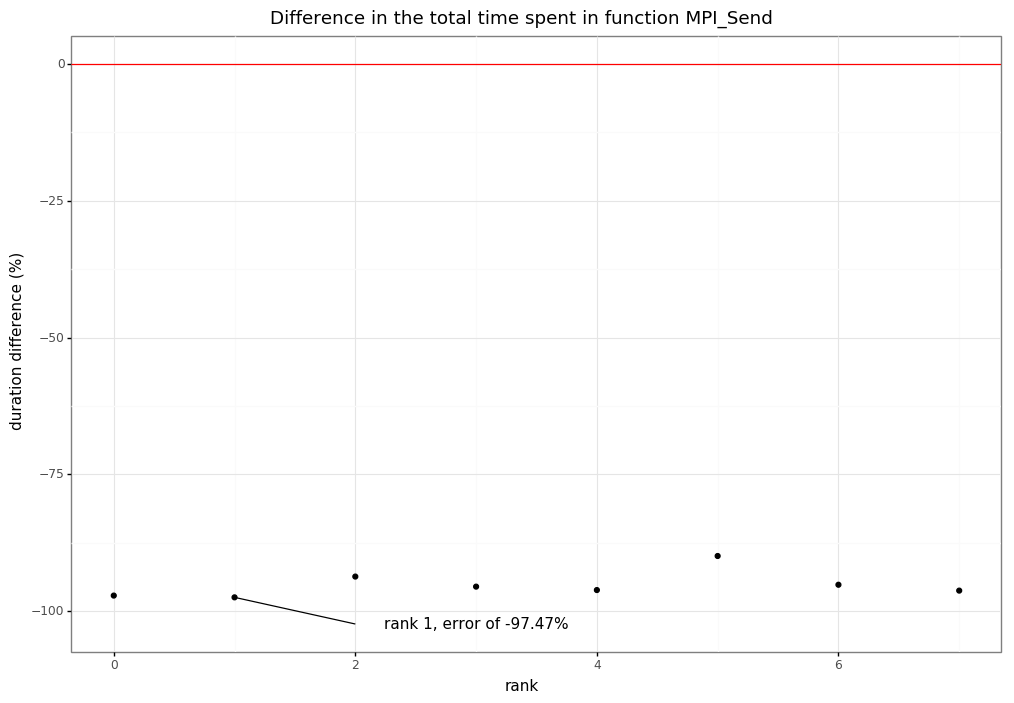

<ggplot: (-9223363251424444100)>


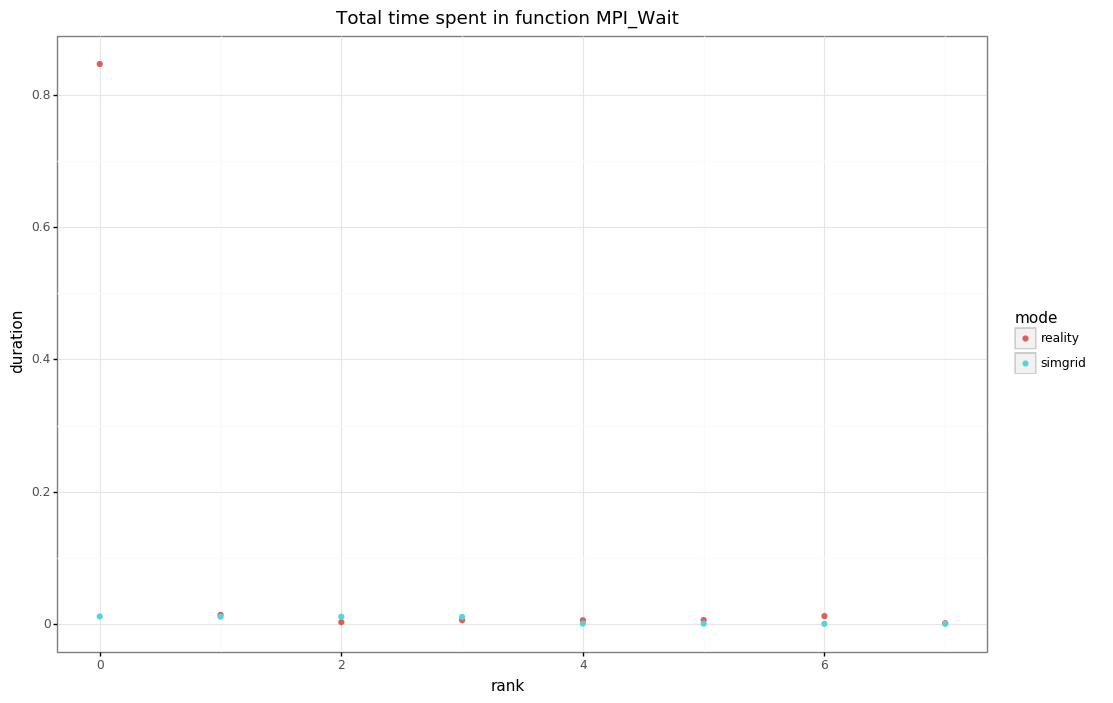

<ggplot: (-9223363251424439657)>


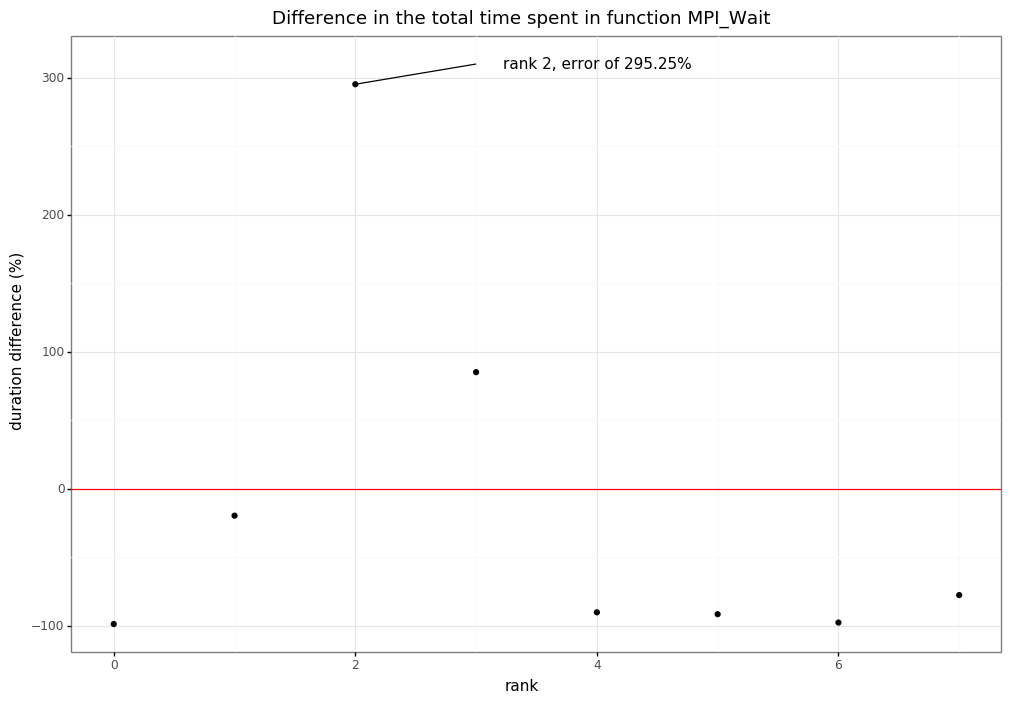

<ggplot: (-9223363251488095109)>


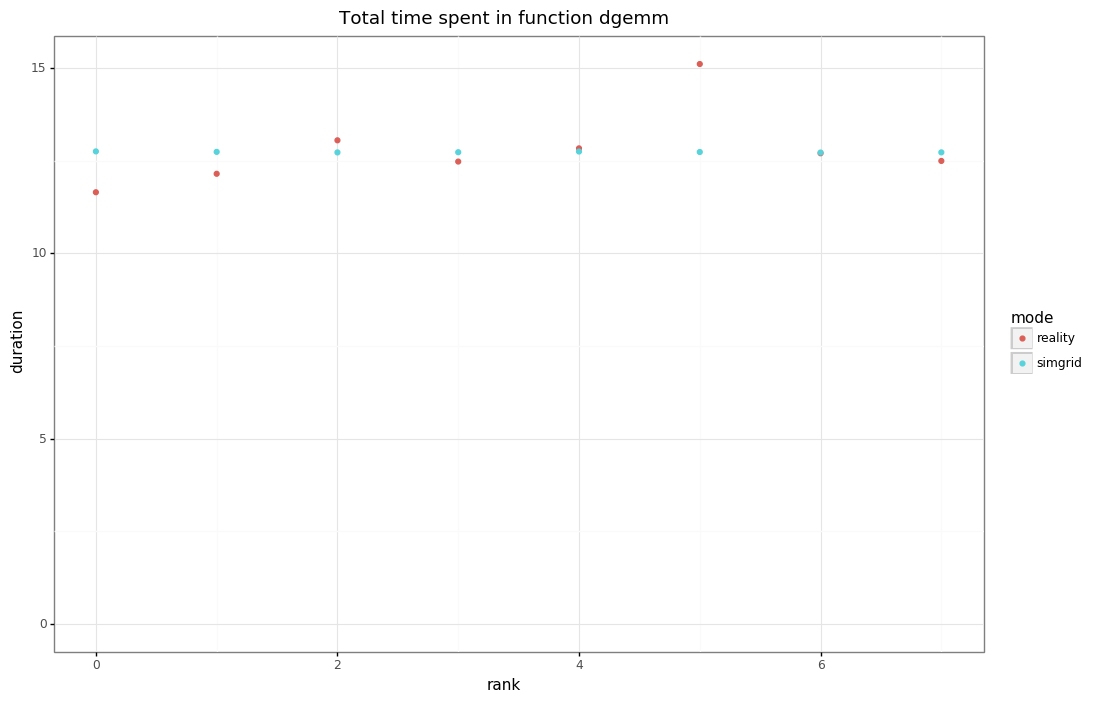

<ggplot: (-9223363251463686228)>


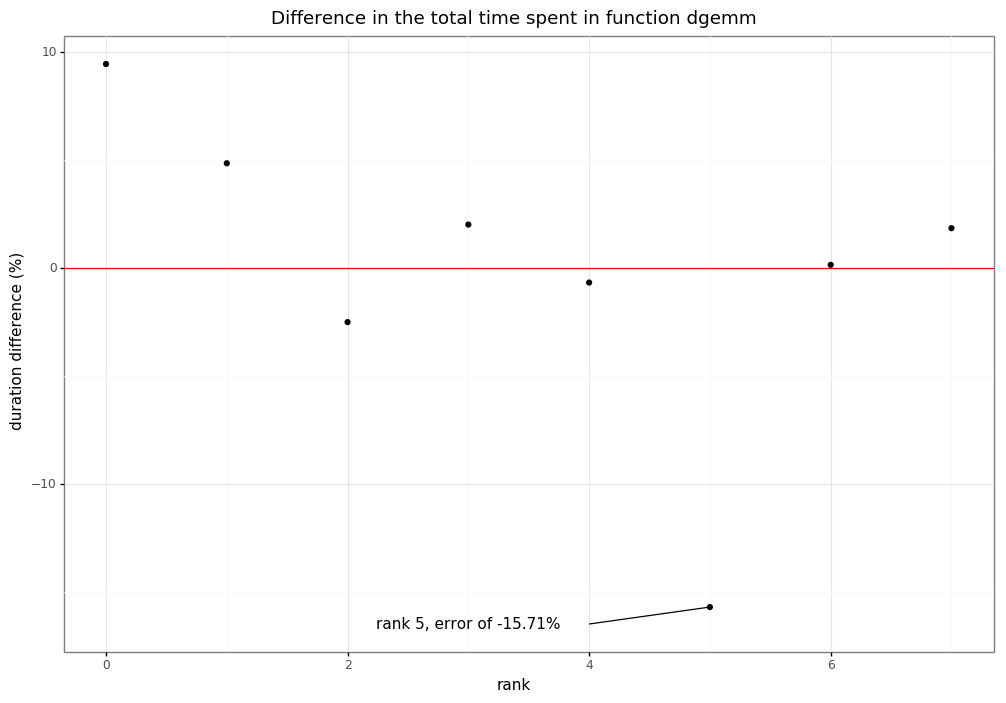

<ggplot: (-9223363251424473393)>


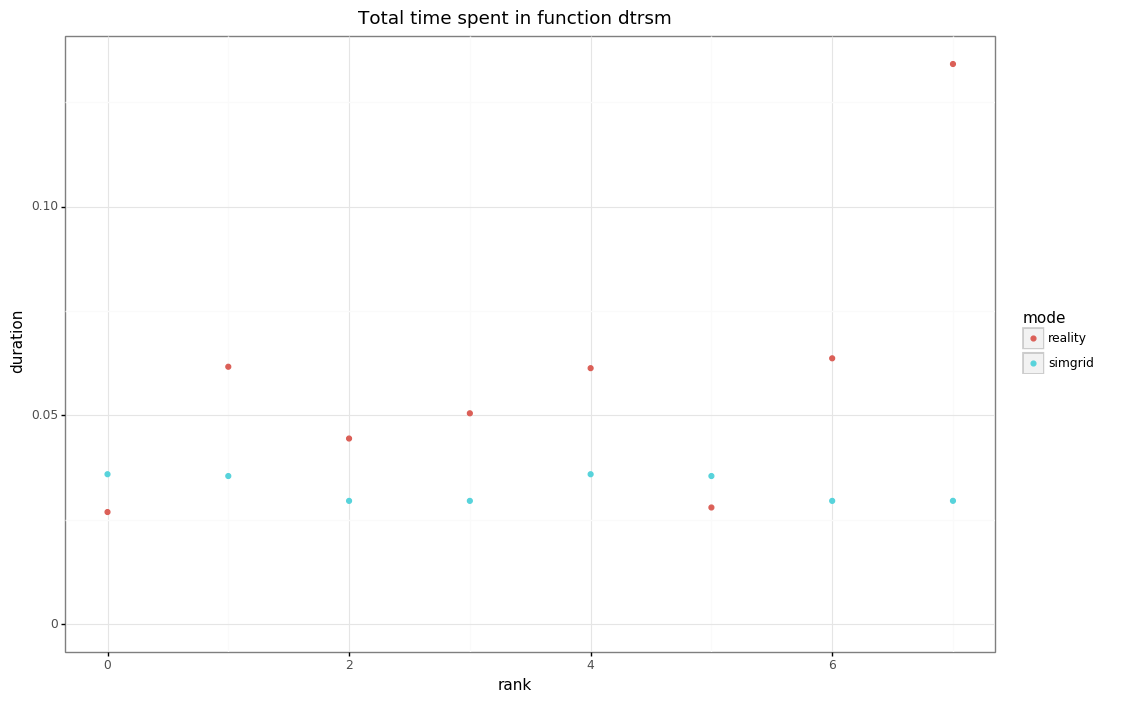

<ggplot: (8785388325552)>


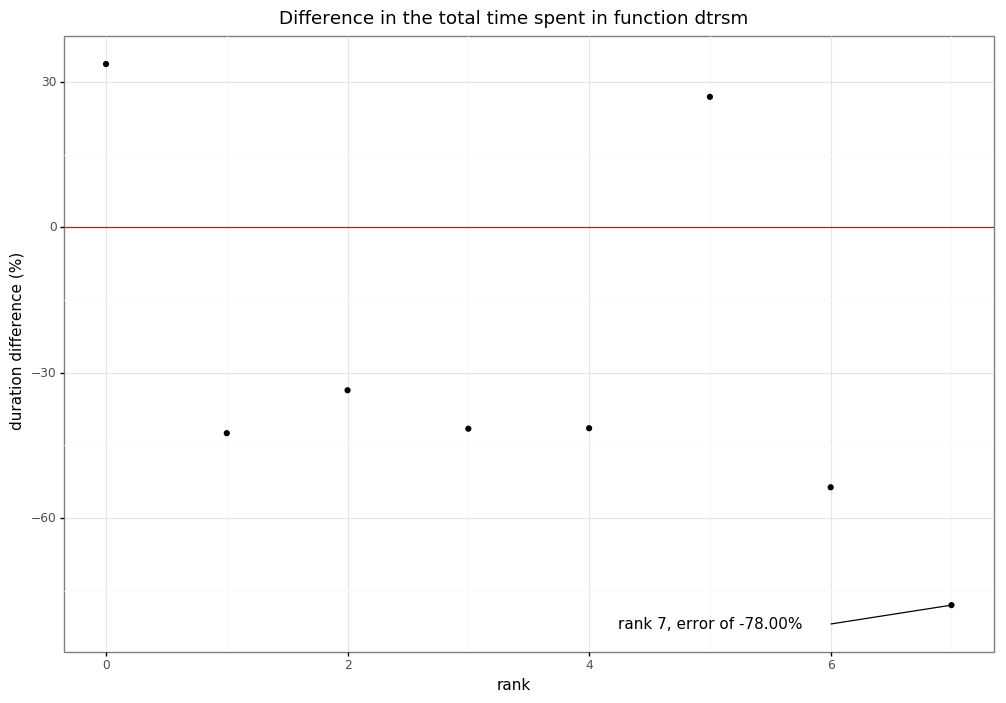

<ggplot: (8785399543318)>


In [17]:
for func in sorted(set(trace_reality.function.unique()) & set(trace_simgrid.function.unique())):
    plot_total_duration(traces, func)

## Computing the average "bandwidth"

Here I divide the number of bytes sent (resp. received) by the time spent in MPI_Send (resp. MPI_Recv).
This does not make any sense for asynchronous calls, but this is roughly equal to the bandwidth for synchronous calls (neglecting the latency).

In [18]:
df = traces[traces.function.isin(['MPI_Recv', 'MPI_Send'])].copy()
df['duration'] = df['end'] - df['start']
df = df.groupby(['rank', 'mode', 'function']).sum().reset_index()
df_reality = df[df['mode'] == 'reality']
df_simgrid = df[df['mode'] == 'simgrid']
df = df_simgrid.set_index(['rank', 'function']).join(df_reality.set_index(['rank', 'function']), rsuffix='_reality').reset_index()
df['duration_simgrid'] = df['duration']
df['bw_simgrid'] = df['msg_size'] / df['duration_simgrid']
df['bw_reality'] = df['msg_size'] / df['duration_reality']
df[['rank', 'function', 'msg_size', 'duration_simgrid', 'duration_reality', 'bw_simgrid', 'bw_reality']]

,rank,function,msg_size,duration_simgrid,duration_reality,bw_simgrid,bw_reality
0,0,MPI_Recv,511709312,0.053081,2.062616,9.640160e+09,2.480875e+08
1,0,MPI_Send,832927228,0.082409,2.886068,1.010724e+10,2.886028e+08
2,1,MPI_Recv,511709364,0.051441,1.910833,9.947500e+09,2.677939e+08
3,1,MPI_Send,832584040,0.078649,3.106923,1.058607e+10,2.679770e+08
4,2,MPI_Recv,639636700,0.076447,3.382447,8.367061e+09,1.891047e+08
5,2,MPI_Send,704601324,0.063773,1.007550,1.104858e+10,6.993214e+08
6,3,MPI_Recv,639636668,0.054352,3.397263,1.176841e+10,1.882800e+08
7,3,MPI_Send,704601168,0.068946,1.535804,1.021961e+10,4.587833e+08
8,4,MPI_Recv,703140084,0.085281,1.865169,8.244979e+09,3.769847e+08
9,4,MPI_Send,767915376,0.076520,1.979852,1.003549e+10,3.878650e+08


In [19]:
df[['function', 'bw_simgrid', 'bw_reality']].groupby('function').mean()

,bw_simgrid,bw_reality
function,,
MPI_Recv,9.705015e+09,2.760477e+08
MPI_Send,1.046925e+10,5.105902e+08


We see here that the "average bandwidth" is about 10 GB/s in Simgrid and less than 500MB/s in reality. The Omnipath links that we have should be 100Gb/s (12.5 GB/s). So maybe we have a problem in reality? Maybe we don't use the right network interface?

In [20]:
matrix_size = read_csv(reality_file, 'exp.csv').matrix_size.unique()[0]
print(matrix_size)

250000


In [21]:
print(matrix_size ** 2 * 8)
print(df[df.function == 'MPI_Recv'].msg_size.sum())
print(df[df.function == 'MPI_Send'].msg_size.sum())

500000000000
5371322892
5888940908


I just checked above if the amount of data sent/received is "normal". For the whole execution, we expect it to be of the same order of magnitude as the memory occupation of the matrix (we did only 5 iterations here).

## Counting the number of events

In [22]:
traces[['function', 'mode', 'rank']].groupby(['function', 'mode']).count()

rank
function  mode         
MPI_Irecv reality  1586
          simgrid  1556
MPI_Recv  reality  5916
          simgrid   135
MPI_Send  reality  7502
          simgrid  1691
MPI_Wait  reality  1586
          simgrid  1556
computing simgrid  5030
dgemm     reality  2942
          simgrid  1686
dtrsm     reality  2942
          simgrid  1686

WTF ?!

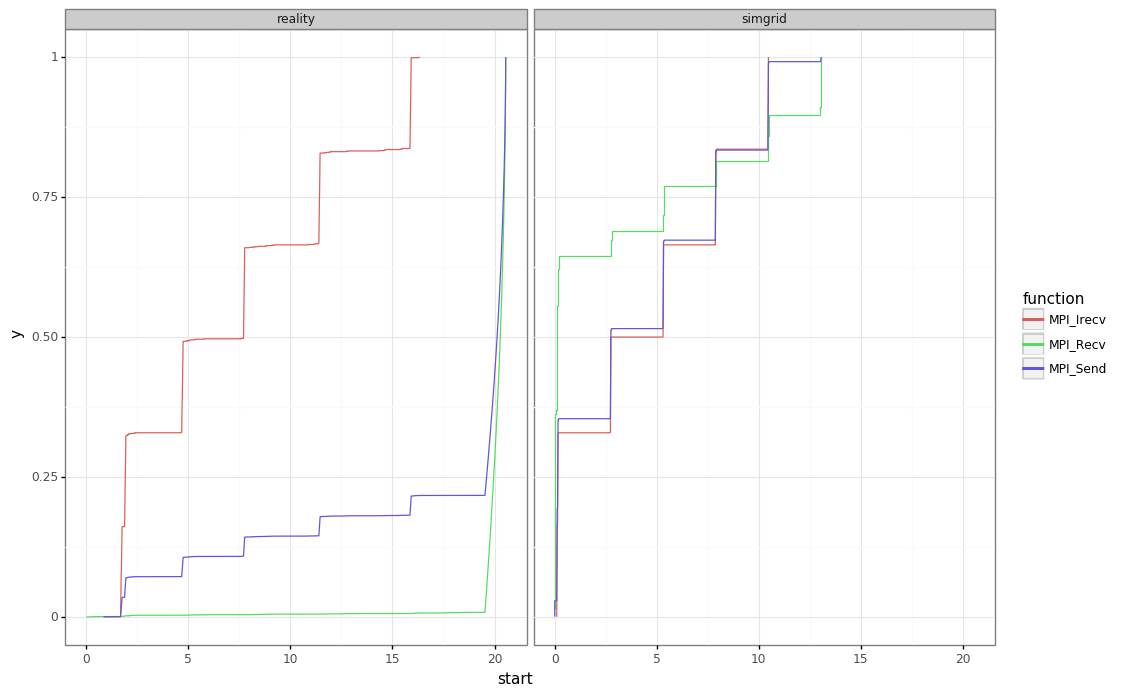

<ggplot: (-9223363251455233827)>

In [23]:
ggplot(traces[traces.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='start', color='function')) + stat_ecdf() + facet_wrap('mode') + theme_bw()

Ok, there is obviously something wrong with the MPI_Recv near the 20th second in the real experiment. Let's zoom on it.

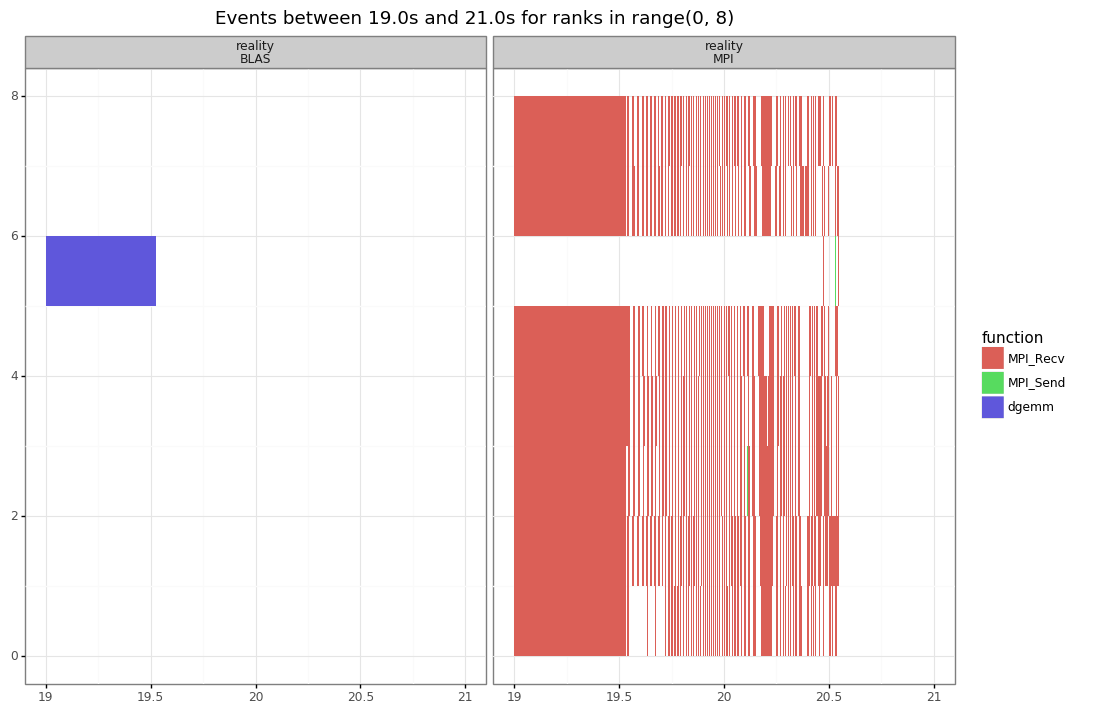

<ggplot: (8785435488667)>

In [24]:
plot_bounded(trace_reality, 19, 21, range(8))

Ok, let's cut at 19.5s.

In [25]:
tmp = traces[traces['start'] <= 19.5]
tmp[['function', 'mode', 'rank']].groupby(['function', 'mode']).count()

rank
function  mode         
MPI_Irecv reality  1586
          simgrid  1556
MPI_Recv  reality    50
          simgrid   135
MPI_Send  reality  1629
          simgrid  1691
MPI_Wait  reality  1586
          simgrid  1556
computing simgrid  5030
dgemm     reality  2942
          simgrid  1686
dtrsm     reality  2942
          simgrid  1686

The numbers for the simulation and the reality are a bit closer, but still significantly different: merging the two traces would be difficult.

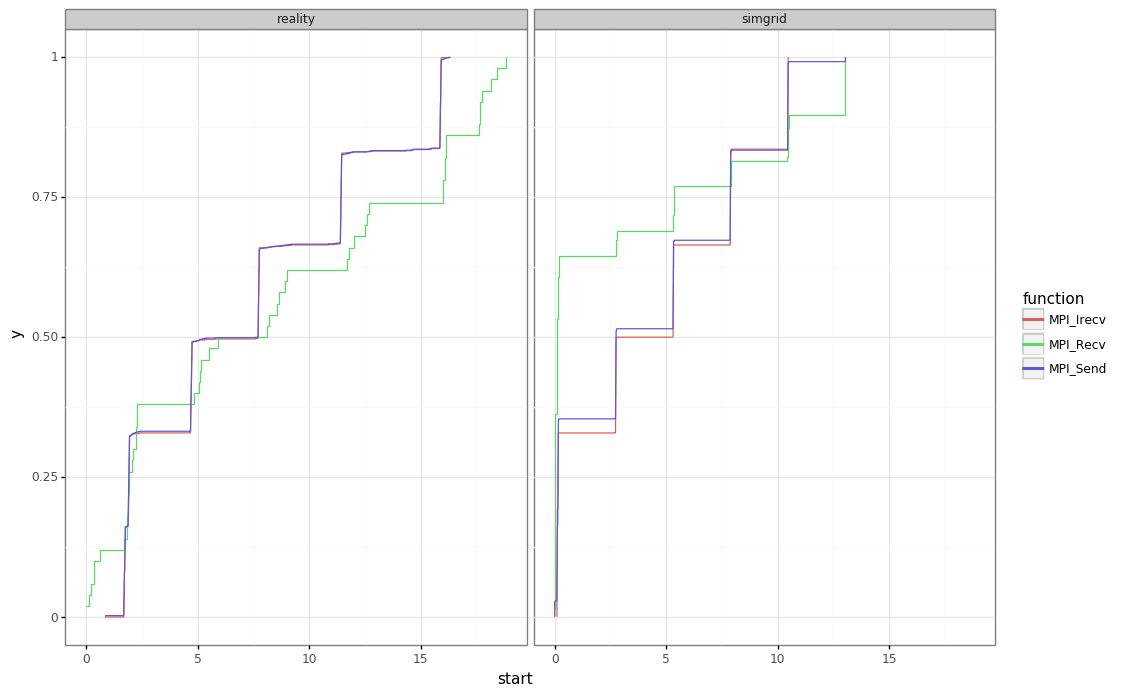

<ggplot: (8785430617299)>

In [26]:
ggplot(tmp[tmp.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='start', color='function')) + stat_ecdf() + facet_wrap('mode') + theme_bw()

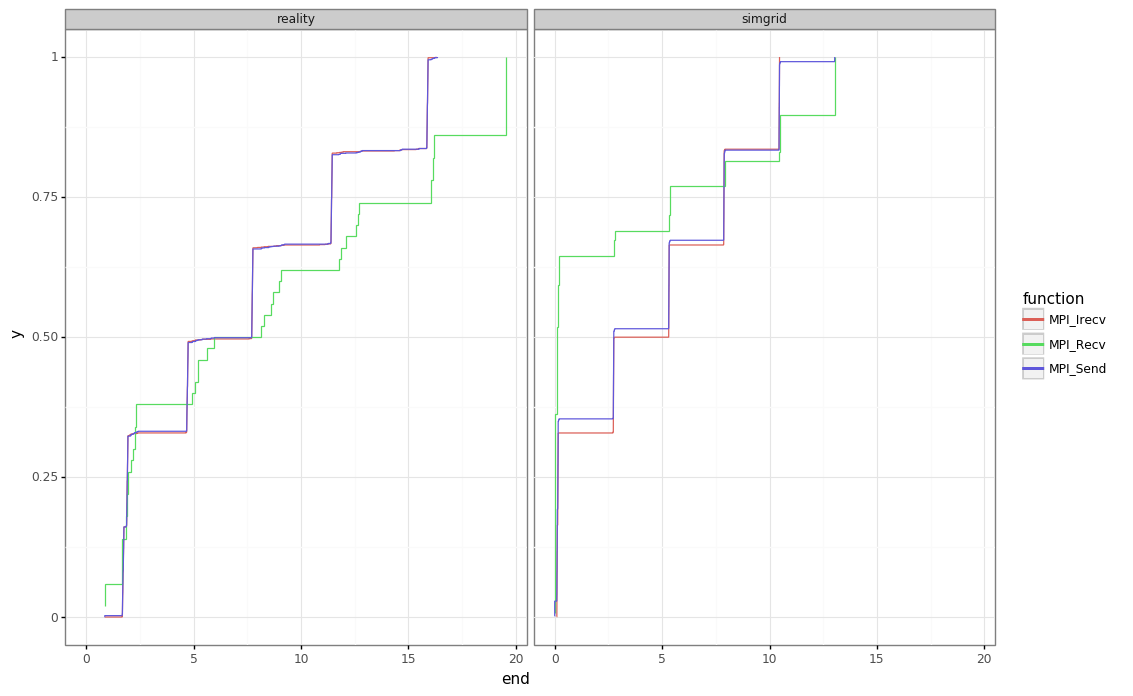

<ggplot: (-9223363251424650720)>

In [27]:
ggplot(tmp[tmp.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='end', color='function')) + stat_ecdf() + facet_wrap('mode') + theme_bw()

There is a huge number of calls to MPI_Recv at the very beggining of the simulation. Let's zoom in.

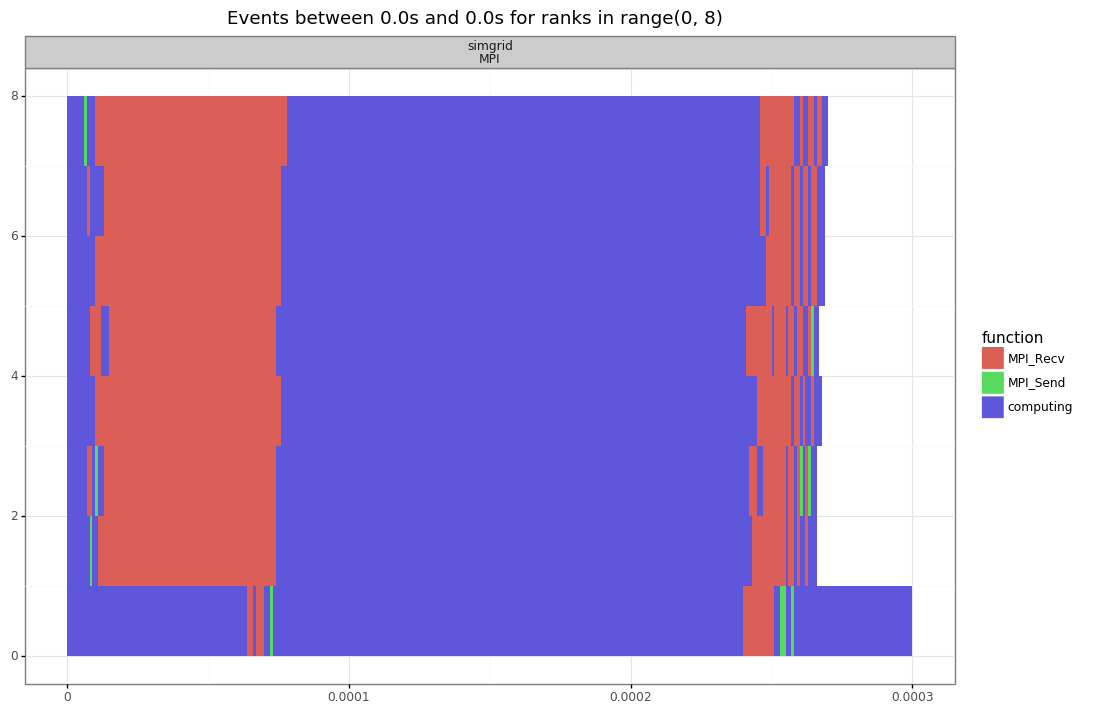

<ggplot: (8785435505584)>

In [28]:
plot_bounded(trace_simgrid, 0, 0.0003, range(8))

In [29]:
trace_simgrid[trace_simgrid['end'] < 0.0003].groupby('function').count()

,start,end,rank,msg_size,kind,mode,rank+1
function,,,,,,,
MPI_Recv,49,49,49,49,49,49,49
MPI_Send,49,49,49,49,49,49,49
computing,65,65,65,65,65,65,65


I think we can safely remove these events as well.

In [30]:
tmp = traces[(traces['start'] <= 19.5) & (traces['end'] >= 0.0003)]
tmp[['function', 'mode', 'rank']].groupby(['function', 'mode']).count()

rank
function  mode         
MPI_Irecv reality  1586
          simgrid  1556
MPI_Recv  reality    50
          simgrid    86
MPI_Send  reality  1629
          simgrid  1642
MPI_Wait  reality  1586
          simgrid  1556
computing simgrid  4965
dgemm     reality  2942
          simgrid  1686
dtrsm     reality  2942
          simgrid  1686

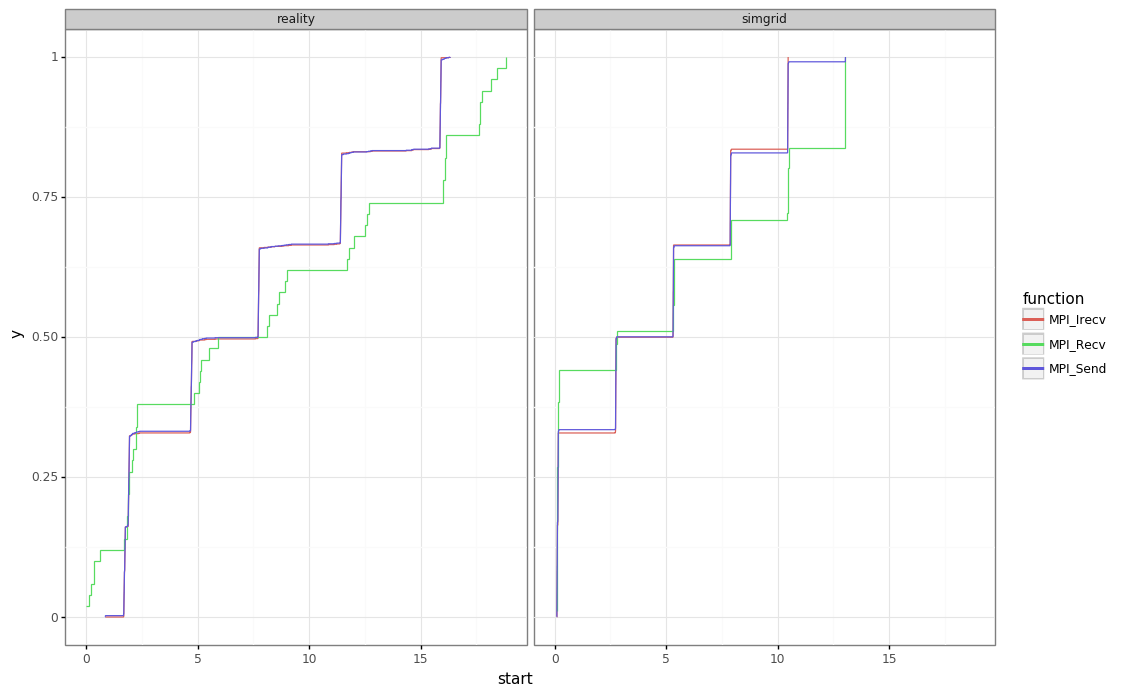

<ggplot: (-9223363251415823279)>

In [31]:
ggplot(tmp[tmp.function.isin(['MPI_Recv', 'MPI_Send', 'MPI_Irecv'])], aes(x='start', color='function')) + stat_ecdf() + facet_wrap('mode') + theme_bw()

Well, I am not so sure anymore on what to conclude here. The MPI_Recv count of the simulation is more reasonable (albeit we still have an important peak at the beginning).